In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#libraries
import cv2
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Load data
train_data_dir=pathlib.Path('/content/drive/MyDrive/ACV/ACV - Project/Dataset_Emotion_Recognition/data/train')
test_data_dir=pathlib.Path('/content/drive/MyDrive/ACV/ACV - Project/Dataset_Emotion_Recognition/data/test')
train_img_count=len(list(train_data_dir.glob('*/*.jpg')))
test_img_count=len(list(test_data_dir.glob('*/*.jpg')))
print(train_img_count,test_img_count)


28830 7066


In [4]:
img_width,img_height=48,48
batch_size=100

In [5]:
#data augmentation
train_data_augmentation=keras.Sequential([layers.Resizing(img_width,img_height),
                                    layers.RandomTranslation(height_factor=0.02, width_factor=0.02),
                                    layers.RandomFlip("horizontal"),
                                    layers.RandomRotation(factor=0.02),
                                    #layers.Rescaling(1.0/255)
                                    ])
test_data_augmentation=keras.Sequential([layers.Resizing(48,48)])

In [94]:
#Load data using Keras utility
train_ds=tf.keras.utils.image_dataset_from_directory(train_data_dir,validation_split=0.2,subset='training',seed=123,image_size=(img_width,img_height),batch_size=batch_size)
val_ds=tf.keras.utils.image_dataset_from_directory(train_data_dir,validation_split=0.2,subset='validation',seed=123,image_size=(img_width,img_height),batch_size=batch_size)
test_ds=tf.keras.utils.image_dataset_from_directory(test_data_dir,seed=123,image_size=(img_width,img_height),batch_size=batch_size)






Found 28830 files belonging to 7 classes.
Using 23064 files for training.
Found 28830 files belonging to 7 classes.
Using 5766 files for validation.
Found 7066 files belonging to 7 classes.
Original label shape: (100,)


In [93]:
aug_train_ds=train_ds.map(lambda x,y:(train_data_augmentation(x,training=True),y))
aug_val_ds=val_ds.map(lambda x,y:(train_data_augmentation(x,training=True),y))
aug_test_ds=test_ds.map(lambda x,y:(test_data_augmentation(x,training=False),y))



Original label shape: (100,)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


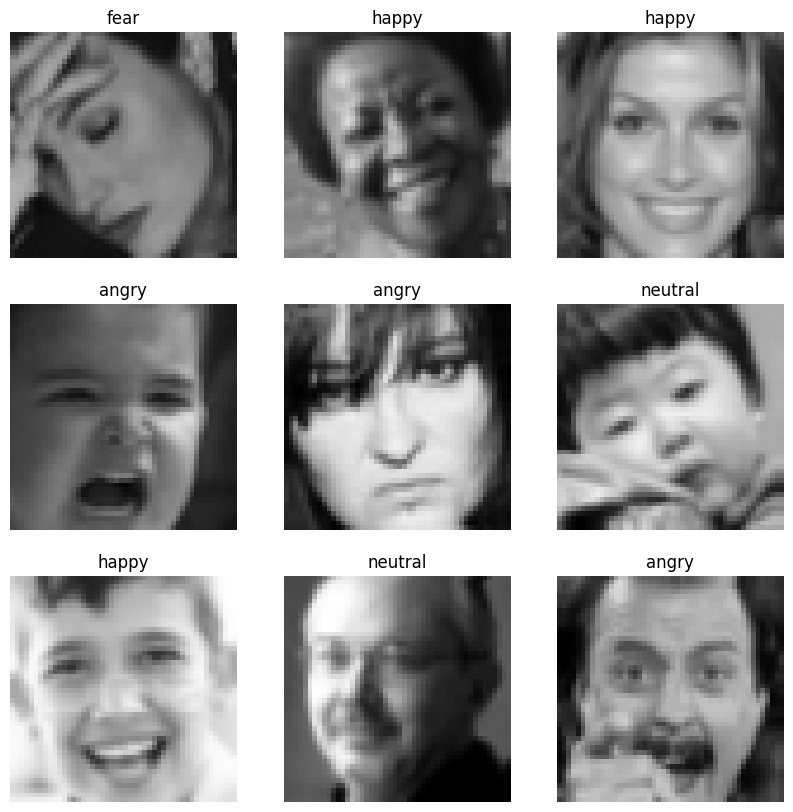

In [8]:
class_names=train_ds.class_names
print(class_names)
num_classes=len(class_names)

#Plot sample images for all the classes
plt.figure(figsize=(10,10))
for images,labels in aug_train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:

def preprocess_one_hot(x,y):
  return x,tf.one_hot(tf.cast(y, tf.int32),num_classes)

In [95]:
#one hot encoding of the output

aug_train_ds_enc= aug_train_ds.map(lambda x,y : preprocess_one_hot(x,y))
aug_val_ds_enc = aug_val_ds.map(lambda x,y : preprocess_one_hot(x,y))
aug_test_ds_enc = aug_test_ds.map(lambda x,y : preprocess_one_hot(x,y))

for images, labels in aug_train_ds_enc.take(1):
    print("Original label shape:", labels.shape)


Original label shape: (100, 7)


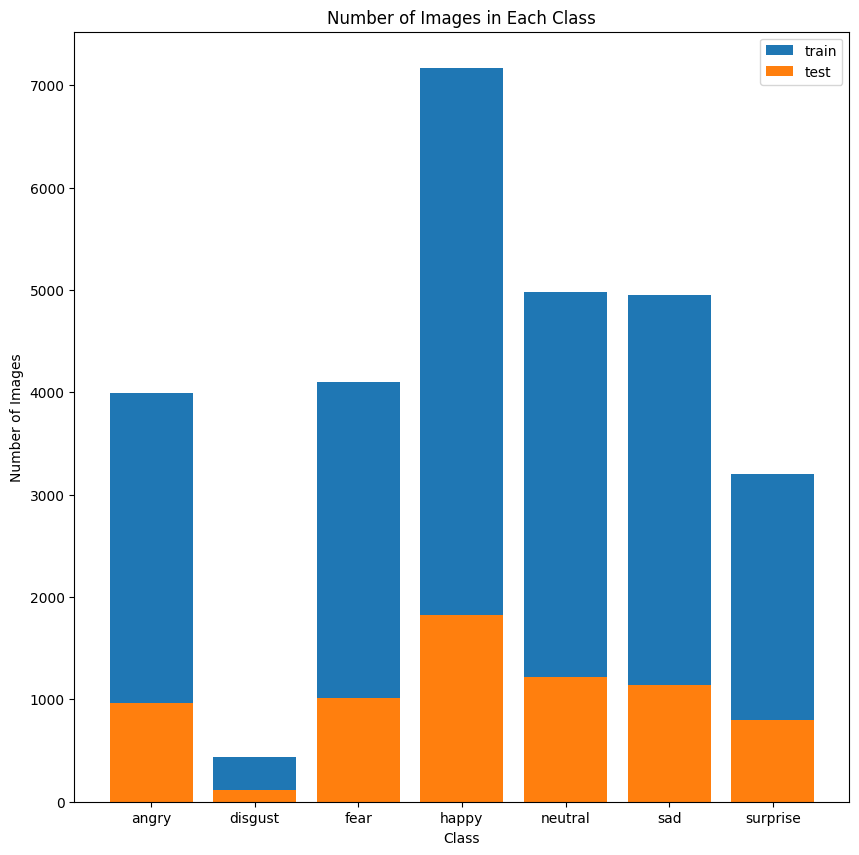

In [11]:
#Plot the bar graph for the number of images in each class for both training and testing data

train_counts=[]
test_counts=[]
for name in class_names:
  train_count=len(list(train_data_dir.glob(name+'/*')))
  test_count=len(list(test_data_dir.glob(name+'/*')))
  train_counts.append(train_count)
  test_counts.append(test_count)

plt.figure(figsize=(10,10))
plt.bar(class_names,train_counts,label='train')
plt.bar(class_names,test_counts,label='test')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.legend()
plt.show()

In [12]:
print("Num GPUS Available: ",len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_logical_devices('GPU')
strategy=tf.distribute.MirroredStrategy(gpus)

Num GPUS Available:  1


In [58]:
#Build Model
with strategy.scope():
  model=Sequential([
      layers.Rescaling(1./255, input_shape=(48, 48, 3)),
      layers.Conv2D(32,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Conv2D(64,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Conv2D(128,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Conv2D(256,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Conv2D(512,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(512,activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(256,activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(num_classes,name='outputs',activation='softmax')
  ])

# Customised CNN

In [42]:
# with strategy.scope():
#   model=Sequential([
#       layers.Rescaling(1./255, input_shape=(48, 48, 3)),
#       layers.Conv2D(16,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(32,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(64,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(128,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Dropout(0.2),
#       layers.Flatten(),
#       layers.Dense(256),
#       layers.LeakyReLU(alpha=0.1),
#       layers.Dense(num_classes,name='outputs')
#   ])

In [59]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_26 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 64)       

In [16]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [60]:

model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [61]:
with strategy.scope():
  epochs=10
  #history=model.fit(aug_train_ds,validation_data=aug_val_ds,epochs=epochs,callbacks=[early_stopping])

  history=model.fit(aug_train_ds,validation_data=aug_val_ds,epochs=epochs)

Epoch 1/10
231/231 [==============================] - 50s 179ms/step - loss: 2.0056 - accuracy: 0.2431 - val_loss: 1.8313 - val_accuracy: 0.2452
Epoch 2/10
231/231 [==============================] - 43s 182ms/step - loss: 1.6810 - accuracy: 0.3487 - val_loss: 1.6090 - val_accuracy: 0.3656
Epoch 3/10
231/231 [==============================] - 41s 174ms/step - loss: 1.5203 - accuracy: 0.4154 - val_loss: 1.4722 - val_accuracy: 0.4364
Epoch 4/10
231/231 [==============================] - 42s 181ms/step - loss: 1.4107 - accuracy: 0.4604 - val_loss: 1.4910 - val_accuracy: 0.4468
Epoch 5/10
231/231 [==============================] - 42s 179ms/step - loss: 1.3378 - accuracy: 0.4890 - val_loss: 1.3715 - val_accuracy: 0.4655
Epoch 6/10
231/231 [==============================] - 40s 169ms/step - loss: 1.2756 - accuracy: 0.5147 - val_loss: 1.3696 - val_accuracy: 0.4716
Epoch 7/10
231/231 [==============================] - 41s 176ms/step - loss: 1.2302 - accuracy: 0.5289 - val_loss: 1.2769 - val_ac

In [62]:
model.save('cnn-emotion.h5')

Text(0.5, 1.0, 'Training and validation accuracy')

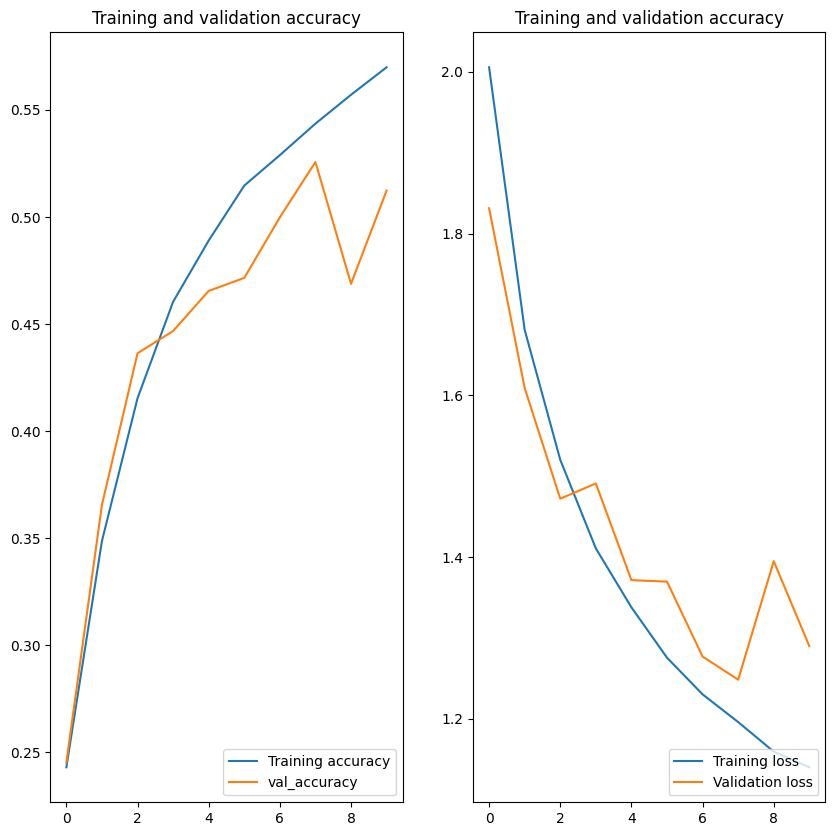

In [63]:
#Plot the training and validation accuracy, and the loss
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training accuracy')
plt.plot(epochs_range,val_acc,label='val_accuracy')
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")

(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 385ms/step
This image #0  most likely belongs to sad with a 41.09 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 341ms/step
This image #1  most likely belongs to neutral with a 61.60 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 146ms/step
This image #2  most likely belongs to angry with a 40.53 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 131ms/step
This image #3  most likely belongs to sad with a 64.53 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 130ms/step
This image #4  most likely belongs to sad with a 38.23 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 272ms/step
This image #5  most likely belongs to surprise with a 39.68 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 

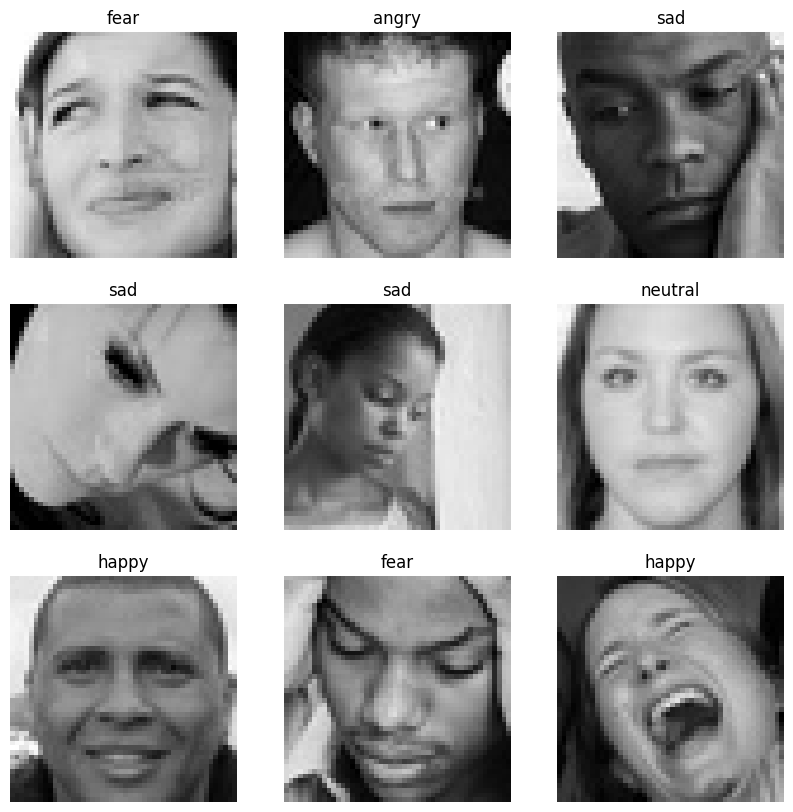

In [108]:
# Predictions and ground truth labels
plt.figure(figsize=(10, 10))
test_labels = []
predictions = []
scores = []

for images, labels in aug_test_ds_enc.take(1):
    for i in range(9):
        print(images.shape,labels.shape)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        img_arr = tf.expand_dims(images[i].numpy().astype('uint8'), 0)
        test_labels.append(np.argmax(labels[i]))

        p = model.predict(img_arr)
        #print(p[i])
        scores.append(p)
        predictions.extend(np.argmax(p, axis=1)) #index of highest predicted value

        print("This image #{}  most likely belongs to {} with a {:.2f} percent confidence."
              .format(i, class_names[np.argmax(p)], 100 * np.max(p)))
print(len(test_labels))
#len(predictions)

In [117]:
from sklearn.metrics import classification_report
predictions = np.array(predictions)
test_labels= np.array(test_labels)
print(len(predictions),len(test_labels))
#scores = np.concatenate(scores, axis=0)  # Concatenate scores from all images
class_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# Calculate classification report
report = classification_report(test_labels, predictions)
print(report)

9 9
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           5       0.50      0.67      0.57         3
           6       0.00      0.00      0.00         0

    accuracy                           0.33         9
   macro avg       0.25      0.19      0.21         9
weighted avg       0.39      0.33      0.34         9



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.